In [1]:
import pystan
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import edward as ed

In [2]:
%matplotlib inline

In [3]:
model_code = """
data {
  int N; //the number of observations
  int N2; //the size of the new_X matrix
  int K; //the number of columns in the model matrix
  vector[N] y; //the response
  matrix[N,K] X; //the model matrix
  matrix[N2,K] new_X; //the matrix for the predicted values
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
generated quantities {
  vector[N2] y_pred;
  y_pred = new_X*beta; //the y values predicted by the model
}
"""

In [4]:
model_name = 'linear_regression'
pkl_file = model_name + '.pkl'

if os.path.isfile(pkl_file):
    # Reuse previously compiled model
    sm = pickle.load(open(pkl_file, 'rb'))
else:
    # Compile and sample model
    sm = pystan.StanModel(model_code=model_code, model_name=model_name)
    with open(pkl_file, 'wb') as f:
        pickle.dump(sm, f)

In [5]:
# Test data
N = 20
beta = np.array([0.2, 1.5]).reshape((-1,1))
x = np.linspace(0, 1, N).reshape((-1, 1))
X = np.column_stack([np.ones(x.shape), x])
y = X.dot(beta) + np.random.normal(0, 0.1, size=N).reshape((-1, 1))

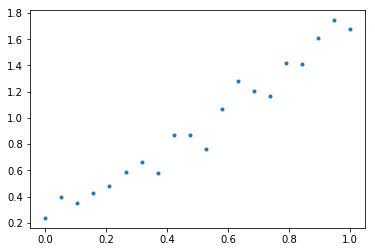

In [6]:
plt.plot(x, y, marker='.', linestyle='none')

In [7]:
# Plot fit
N2 = 2
new_x =  np.linspace(0, 1, N2).reshape((-1, 1))
new_X = np.column_stack([np.ones(N2).reshape((-1, 1)), new_x])

In [8]:
data = {
    'N': N,
    'X': X,
    'K': X.shape[1],
    'y': y.flatten(), 
    'N2': N2,
    'new_X': new_X
}

In [9]:
res = sm.optimizing(data=data)

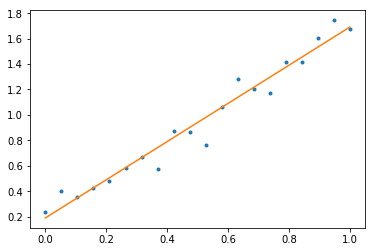

In [10]:
# Plot MLE fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(new_x, res['y_pred'])
plt.show()

In [11]:
res_vb = sm.vb(data=data, pars=['beta', 'y_pred'])
out_file = res_vb['args']['sample_file']
df = pd.read_csv(out_file, comment='#').iloc[2:, :]

In [12]:
df.describe()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
count,999.0,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.0,0.248237,1.413918,0.276710,0.248237,0.322653,0.397070,0.471487,0.545903,0.620320,...,1.141237,1.215654,1.290071,1.364487,1.438904,1.513321,1.587738,1.662154,0.248237,1.662154
std,0.0,0.078315,0.131872,0.150637,0.078315,0.078422,0.079141,0.080454,0.082333,0.084740,...,0.112668,0.117758,0.123030,0.128460,0.134030,0.139723,0.145523,0.151420,0.078315,0.151420
min,0.0,-0.003841,0.915943,-0.230153,-0.003841,0.066752,0.129104,0.191456,0.253807,0.316159,...,0.752621,0.814972,0.877324,0.931818,0.984863,1.037910,1.090950,1.144000,-0.003841,1.144000
25%,0.0,0.196601,1.325075,0.174872,0.196601,0.271388,0.345764,0.419563,0.492305,0.564822,...,1.067380,1.136820,1.207695,1.278645,1.348935,1.420015,1.491150,1.561020,0.196601,1.561020
50%,0.0,0.248528,1.419840,0.269580,0.248528,0.321691,0.396606,0.470693,0.545711,0.620346,...,1.139220,1.215460,1.290090,1.365160,1.438510,1.512500,1.588120,1.663190,0.248528,1.663190
75%,0.0,0.302165,1.501550,0.376862,0.302165,0.376418,0.450848,0.526371,0.603460,0.679519,...,1.215055,1.293350,1.373265,1.451985,1.529320,1.605525,1.683945,1.762220,0.302165,1.762220
max,0.0,0.496061,1.854010,0.788685,0.496061,0.566389,0.636717,0.710322,0.788418,0.866514,...,1.513820,1.611400,1.708980,1.806560,1.904140,2.001720,2.099300,2.196880,0.496061,2.196880


In [13]:
df.head()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
2,0,0.175881,1.61856,0.291169,0.175881,0.261068,0.346256,0.431444,0.516631,0.601819,...,1.19813,1.28332,1.36851,1.45369,1.53888,1.62407,1.70926,1.79444,0.175881,1.79444
3,0,0.165420,1.45026,0.467249,0.165420,0.241750,0.318079,0.394409,0.470738,0.547068,...,1.08137,1.15770,1.23403,1.31036,1.38669,1.46302,1.53935,1.61568,0.165420,1.61568
4,0,0.286881,1.42606,0.367377,0.286881,0.361937,0.436993,0.512049,0.587105,0.662161,...,1.18755,1.26261,1.33767,1.41272,1.48778,1.56283,1.63789,1.71295,0.286881,1.71295
5,0,0.313728,1.44436,0.146675,0.313728,0.389747,0.465766,0.541785,0.617803,0.693822,...,1.22595,1.30197,1.37799,1.45401,1.53003,1.60605,1.68207,1.75809,0.313728,1.75809
6,0,0.209218,1.45800,0.168183,0.209218,0.285954,0.362691,0.439428,0.516164,0.592901,...,1.13006,1.20679,1.28353,1.36027,1.43700,1.51374,1.59048,1.66721,0.209218,1.66721


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ad4081590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3ad3fb7c10>]], dtype=object)

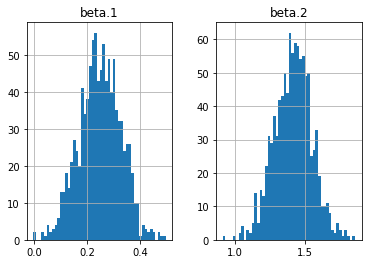

In [14]:
df[['beta.1', 'beta.2']].hist(bins=50)

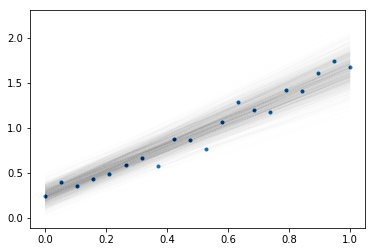

In [15]:
# Plot with generated values after Variational Bayes fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(np.tile(new_x, (1, len(df))), df[['y_pred.1', 'y_pred.2']].T.values, alpha=0.005, c='k')
plt.show()

# Edward
Try to replicate Bayesian linear regression using Edward - see http://edwardlib.org/tutorials/supervised-regression

In [16]:
Beta_ed = ed.models.Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
X_ed = tf.placeholder(tf.float32, [N, 2])  # X.astype(np.float32)
y_ed = ed.models.Normal(loc=tf.matmul(X_ed, Beta_ed), scale=0.5)

In [17]:
# Different prior - doesn't seem to be a Cauchy distribution in Edward
qBeta = ed.models.Normal(
    loc=tf.Variable(tf.zeros([2, 1])), 
    scale=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))

In [18]:
inference = ed.KLqp({Beta_ed: qBeta}, data={X_ed: X, y_ed: y})

In [19]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 10.4260s | Loss:


In [20]:
n_sample = 1000
df_ed = pd.DataFrame(qBeta.sample(n_sample).eval().reshape((n_sample, -1)), columns=['beta.1', 'beta.2'])

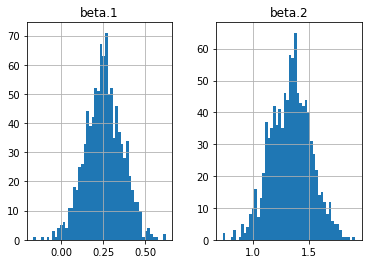

In [21]:
df_ed[['beta.1', 'beta.2']].hist(bins=50)
plt.show()

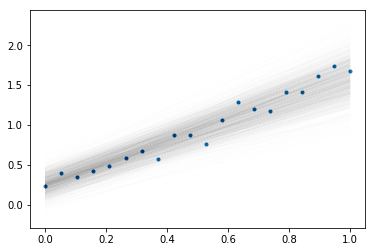

In [22]:
# Plot with generated values after Variational Bayes fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(np.tile(new_x, (1, len(df_ed))), 
          new_X.dot(df_ed[['beta.1', 'beta.2']].values.T), alpha=0.005, c='k')
plt.show()